## Generate plots from H(x) IODA files of each AOD product
This notebook can generate horizontal scatter plot (if `pltcyc` is True), density distribution (if `pltstats` is True), and OMB PDF for all listed obs (if `all_omb_stats` is True).

In [1]:
import os
from tqdm import tqdm
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mpcrs
from custom_colormaps import white_gist_earth
from functions import set_size, setupax_2dmap, setup_cmap, get_dates
from joblib import Parallel, delayed

### Setup the running period, features of figure, and processing observations

In [10]:
sdate = 2024110100
edate = 2024113018
date_interval = 6
dates = get_dates(sdate, edate, date_interval)
bkg = 'MERRA-2'
plot_wvl = 550  # change it to 500 for AERONET H(x)
plotvar = 'aerosolOpticalDepth'
pltcyc = False
pltstats = True
show_stats = True
all_omb_stats = False
fsave = 1
quality = 600
# Plotting setup
txsize = 14
mpl.rc('axes', titlesize=txsize, labelsize=txsize)
mpl.rc('xtick', labelsize=txsize)
mpl.rc('ytick', labelsize=txsize)
mpl.rc('legend', fontsize='large')

In [3]:
# control PDF, boxplot
binwidth = 0.1
halfbin = binwidth/2
binmax = 2.
bins = np.arange(0., binmax + halfbin, binwidth)
bin_lb = [round(l, 2) for l in np.arange(0. + halfbin, binmax, binwidth)]
bin_lb_str = [f'{l:.2f}' for l in bin_lb]
zero_c_bins = np.arange(-binmax+halfbin, binmax + halfbin, binwidth)
zero_c_bin_lb = np.where(abs(np.arange(-binmax+binwidth, binmax, binwidth)) < 1e-10,
                         0, np.arange(-binmax+binwidth, binmax, binwidth))
zero_c_bin_lb = [round(l, 2) for l in zero_c_bin_lb]
zero_c_bin_lb_str = [f'{l:.2f}' for l in zero_c_bin_lb]

# Control hist2d
hist2d_in_log = 1
hist2d_xmax = 5.0
hist2d_xybins = 30
if hist2d_in_log:
    h2d_axis = np.linspace(np.log(0.01), np.log(hist2d_xmax), hist2d_xybins+1)
    h2d_axis = np.exp(h2d_axis)
else:
    h2d_axis = np.linspace(0.01, hist2d_xmax, hist2d_xybins+1)

In [4]:
hofx_path = '/glade/work/swei/Git/JEDI-METplus/output/aodobs_merra2/hofx/f00'
obs_name_list = [
    # 'aeronet_l15_aod',
    # 'modis_terra_aod', 'modis_aqua_aod',
    'pace_aod',
    # 'viirs_aod_dt_npp', 'viirs_aod_dt_n20',
    # 'viirs_aod_db_npp', 'viirs_aod_db_n20',
]
vardict = {
    'obs': 'Obs',
    'omb': 'OMBs',
    'hfx': 'H(x)',
}

aeronet_aod_wvl = [340., 380., 440., 500., 675, 870., 1020., 1640.]

data_name_dict = {
    'pace_aod': 'OCI UAA AOD on PACE',
    'modis_aqua_aod': 'MODIS AOD on Aqua',
    'modis_terra_aod': 'MODIS AOD on Terra',
    'viirs_aod_dt_n20': 'VIIRS DT AOD on NOAA-20',
    'viirs_aod_db_n20': 'VIIRS DB AOD on NOAA-20',
    'viirs_aod_dt_npp': 'VIIRS DT AOD on Suomi-NPP',
    'viirs_aod_db_npp': 'VIIRS DB AOD on Suomi-NPP',
    'aeronet_l15_aod': 'AERONET Level 1.5 AOD',
}
shortvar_dict = {
    'aerosolOpticalDepth': 'AOD'
}

In [5]:
savedir = '/glade/work/swei/projects/mmm.pace_aod/plots'
cycs_savedir = f'{savedir}/cycles'
stat_savedir = f'{savedir}/stats/'
if not os.path.exists(stat_savedir):
    os.makedirs(stat_savedir)
for varType in vardict.keys():
    for obsname in obs_name_list:
        cycdir = f'{cycs_savedir}/{varType}/{obsname}'
        if not os.path.exists(cycdir):
            os.makedirs(cycdir)

### Define local functions

In [6]:
def plt_glb_scatter(dataset, vartype, titlestr, save, savename):
    pltds = dataset
    fig, ax, gl = setupax_2dmap([-180., 180., -90., 90.,], ccrs.PlateCarree(), lbsize=12)
    set_size(8, 6)
    if vartype == 'omb':
        sc = ax.scatter(
            pltds.lon,
            pltds.lat,
            c=pltds[vartype],
            s=1,
            vmin=-0.5,
            vmax=0.5,
            cmap='RdBu_r'
        )
        cnlvs = np.linspace(-0.5, 0.5, 11)
    else:
        cnlvs = [0., 0.05, 0.1, 0.15, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.5, 2.5]
        clridx = [2, 4, 5, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18]
        tuplelst, aodcmap = setup_cmap('precip3_16lev', clridx)
        clr_norm = mpcrs.BoundaryNorm(cnlvs, len(clridx), extend='both')
        sc = ax.scatter(
            pltds.lon,
            pltds.lat,
            c=pltds[vartype],
            s=1,
            # levels=cnlvs,
            edgecolors='none',
            cmap=aodcmap,
            norm=clr_norm,
        )
    plt.colorbar(sc, fraction=0.025, pad=0.04, aspect=20, extend='both', ticks=cnlvs)
    ax.set_title(titlestr)

    if save:
        fig.savefig(savename, dpi=quality)
    # plt.close()
    return

In [7]:
def plt_hist2d(dataframe, x, y, axis, show_stats, save, savename, **kwargs):
    x_data = dataframe[x]
    y_data = dataframe[y]
    xlbstr = kwargs.get('xlb', x)
    ylbstr = kwargs.get('ylb', y)
    hist2d, x_edge, y_edge = np.histogram2d(x_data,
                                            y_data,
                                            bins=axis)

    cnlvs = np.linspace(0, hist2d.max(), 256)
    clrnorm = mpcrs.BoundaryNorm(cnlvs, len(cnlvs), extend='max')

    fig, ax = plt.subplots()
    set_size(5, 5, b=0.1, l=0.1, r=0.95, t=0.95)
    cn = ax.contourf(axis[:-1], axis[:-1], hist2d.swapaxes(0,1),
                     levels=cnlvs, norm=clrnorm, cmap=white_gist_earth,
                     extend='max',)
    plt.plot(
        [0.0, hist2d_xmax],
        [0.0, hist2d_xmax],
        color='gray',
        linewidth=2,
        linestyle='--'
    )
    plt.xlim(0.01, hist2d_xmax)
    plt.ylim(0.01, hist2d_xmax)

    if hist2d_in_log:
        ax.set_xscale('log')
        ax.set_yscale('log')
    ax.set_aspect('equal')

    plt.grid(alpha=0.5)
    plt.xlabel(xlbstr)
    plt.ylabel(ylbstr)

    # Calculate statistics and place it on the top-left corner
    if show_stats:
        correlation_matrix = np.corrcoef(x_data, y_data)
        correlation_xy = correlation_matrix[0, 1]
        r_squared = correlation_xy ** 2
        bias = np.mean(y_data) - np.mean(x_data)
        rbias = bias/np.mean(x_data)
        ssize = len(x_data)
        rmse = np.sqrt(np.mean((y_data - x_data) ** 2))
        stats_dict = {
            'Counts': str("%.0f" % ssize),
            'Absolute Bias': str("%.3f" % bias),
            'Relative Bias': str("%.3f" % rbias),
            'RMSE': str("%.3f" % rmse),
            # 'R': str("%.3f" % correlation_xy),
            'R\u00b2': str("%.3f" % r_squared),
        }
        x_pos = 0.012
        y_pos = 1.02
        for key in stats_dict.keys():
            stat_str = '%s= %s' %(key, stats_dict[key])
            y_pos = y_pos - 0.05
            ax.annotate(stat_str, (x_pos, y_pos), ha='left', va='center', 
                        fontsize=12, xycoords='axes fraction')

    cb = plt.colorbar(cn, orientation='horizontal', fraction=0.03, aspect=30, 
                      pad=0.12, extend='max', ticks=cnlvs[::50])
    cb.ax.minorticks_off()
    cb.ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0),
                           useMathText=True)

    if save:
        plt.savefig(savename, dpi=quality)
    # plt.close(fig)
    return

In [8]:
def plt_all_omb_hist(key, dataframe, save, savename, **kwargs):
    ax = dataframe.plot.line()
    yval = [round(y, 1) for y in ax.get_yticks()]
    ylb = [round(y*binwidth*100., 1) for y in yval]
    ax.set_xlabel(f'{plotvar} (Obs minus {bkg})')
    ax.set_ylabel('Frequency [%]')
    ax.set_yticks(yval)
    ax.set_yticklabels(ylb)
    ax.grid(axis='x')
    ax.set_ylim(bottom=0.)
    ax.set_xlim(-1, 1)
    ax.set_title(key, loc='left')
    if save:
        plt.savefig(savename, dpi=quality)
    plt.close()
    return

In [9]:
def process_dates(cdate, obsname):
    cdate_str = cdate.strftime('%Y%m%d%H')
    hofxfile = f'{hofx_path}/{obsname}/hofx.{obsname}.{cdate_str}.nc4'
    metads = xr.open_dataset(hofxfile, group='MetaData')
    if 'aeronet' in obsname:
        ch_wvl = aeronet_aod_wvl
    elif 'pace' in obsname:
        ch_wvl = metads.sensorCentralWavelength.values * 1e3
    else:
        ch_wvl = [550.]

    obsvds = xr.open_dataset(hofxfile, group='ObsValue').assign_coords(Channel=ch_wvl)
    hofxds = xr.open_dataset(hofxfile, group='hofx').assign_coords(Channel=ch_wvl)

    tmpdf = pd.DataFrame()
    tmpdf['lat'] = metads['latitude']
    tmpdf['lon'] = metads['longitude']
    tmpdf['obs'] = obsvds['aerosolOpticalDepth'].sel(Channel=plot_wvl)
    tmpdf['hfx'] = hofxds['aerosolOpticalDepth'].sel(Channel=plot_wvl)
    tmpdf['omb'] = tmpdf['obs'] - tmpdf['hfx']

    if 'aeronet' not in obsname:
        tmpdf['lsf'] = metads['surfaceQualifier']

    if pltcyc:
        for var in ['obs', 'omb', 'hfx']:
            titlestr = f'{vardict[var]} of {data_name_dict[obsname]} at {cdate_str}'
            sc2dplt = f'{cycs_savedir}/{var}/{obsname}/{var}2d.{obsname}.{cdate_str}.png'
            plt_glb_scatter(tmpdf, var, titlestr, fsave, sc2dplt)

    return tmpdf

### Loop through each observation for the whole period 
It creates the Dataframe for density distribution and OMB histogram plots

Processing pace_aod


100%|██████████| 120/120 [00:10<00:00, 11.38it/s]


/glade/work/swei/projects/mmm.pace_aod/plots/stats//all.hist2d.pace_aod.550nm.2024110100_2024113018.png
/glade/work/swei/projects/mmm.pace_aod/plots/stats//water.hist2d.pace_aod.550nm.2024110100_2024113018.png
/glade/work/swei/projects/mmm.pace_aod/plots/stats//land.hist2d.pace_aod.550nm.2024110100_2024113018.png
pace_aod finished
Process Finished


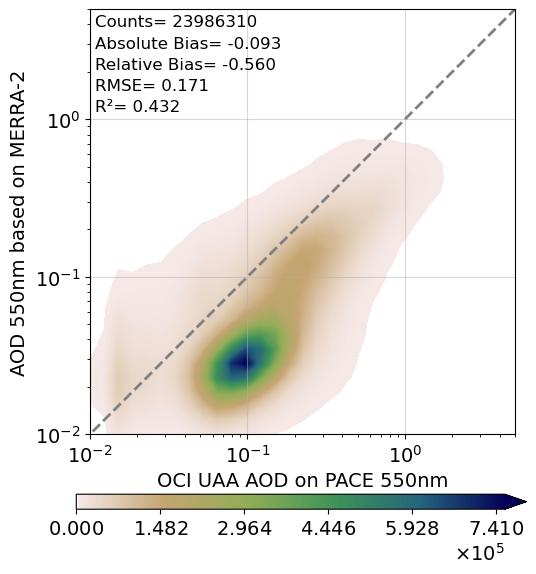

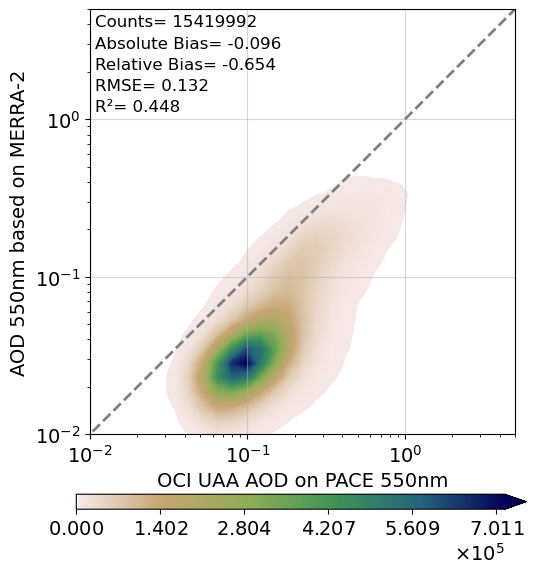

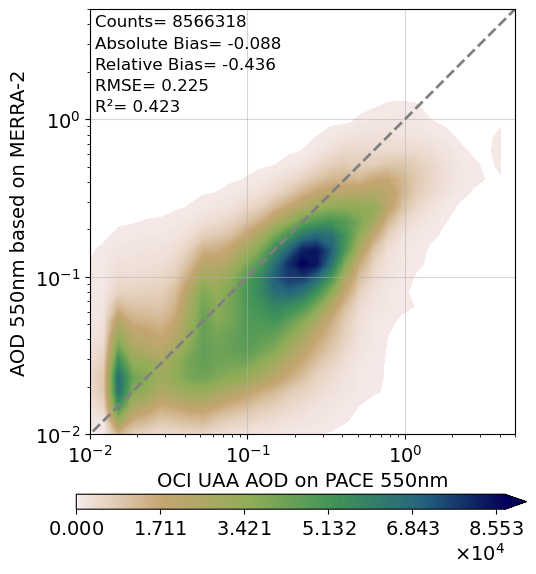

In [11]:
out_dict = {}
for obs in obs_name_list:
    print(f'Processing {obs}')
    results = Parallel(n_jobs=-1)(delayed(process_dates)(cdate, obs) for cdate in tqdm(dates))
    alldf = pd.concat(results, ignore_index=True)
    msking_dict = {
        'all': ~alldf['obs'].isnull(),
    }
    if 'aeronet' not in obs:
        msking_dict['water'] = (alldf['lsf'] == 0),
        msking_dict['land'] = (alldf['lsf'] != 0),

    # stratified based on obs aod
    if pltstats:
        for key, mask in msking_dict.items():
            pltdf = alldf.loc[mask].reset_index(drop=True)
            pltdf['obs_bin'] = pd.cut(pltdf['obs'], bins=bins, labels=bin_lb, right=True)

            hist2dplt = f'{stat_savedir}/{key}.hist2d.{obs}.{plot_wvl}nm.{sdate}_{edate}.png'
            plt_hist2d(pltdf, 'obs', 'hfx', h2d_axis, show_stats, fsave, hist2dplt,
                       xlb=f'{data_name_dict[obs]} {plot_wvl}nm',
                       ylb=f'{shortvar_dict[plotvar]} {plot_wvl}nm based on {bkg}')
            print(hist2dplt)

    if all_omb_stats:
        # Calculate histogram and return the dataset for merge
        for key, mask in tqdm(msking_dict.items()):
            # column_name = f'{obsname}_{key}'
            columns = pd.MultiIndex.from_tuples([(key, obs)])
            out_dict[(key, obs)], bin_edges = np.histogram(
                pltdf['omb'].loc[mask].reset_index(drop=True),
                density=True,
                bins=zero_c_bins,
            )

    print(f'{obs} finished')

if all_omb_stats:
    df = pd.DataFrame(out_dict)
    df.index = zero_c_bin_lb

    for key in ['all', 'water', 'land']:
        ombhistplt = f'{stat_savedir}/allombhist.{key}.{sdate}_{edate}.png'
        plt_all_omb_hist(key.capitalize(), df[key], fsave, ombhistplt)

print('Process Finished')